In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from termcolor import colored
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def get_negative_positive_sentiment(df):
    negative_sentiment = df[(df.rating == 0)]
    positive_sentiment = df[(df.rating == 1)].sample(frac=1)[:len(negative_sentiment)]
    new_df = pd.concat([negative_sentiment, positive_sentiment])
    return new_df['review'], new_df['rating']

In [3]:
def bag_of_words(classifier, tf_idf=False):
    if tf_idf:
        steps = [("vect", TfidfVectorizer())]
    else:
        steps = [("vect", CountVectorizer())]

    steps.append(("cls", classifier))
    return Pipeline(steps)

In [32]:
def plot_roc_curve(y_test, prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    plt.figure()
    plt.plot(fpr, tpr, label='LinearSVC (area = {}0.2f)'.format(roc_auc_score(y_test, probs)))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
def plot_top_features(coef, cv):
    top_features = 20
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(cv.get_feature_names())
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

In [5]:
train_df = pd.read_csv('../data/processed/train.csv').sample(frac=1)
train_df.dropna(inplace=True)
samples, labels = get_negative_positive_sentiment(train_df)

test_df = pd.read_csv('../data/processed/test.csv').sample(frac=1)
test_df.dropna(inplace=True)
X_test, y_test = get_negative_positive_sentiment(test_df)

In [6]:
classifier_tfidf = LinearSVC(max_iter=2000, random_state=0)
model_tfidf = bag_of_words(classifier_tfidf, True)
model_tfidf.set_params(vect__ngram_range=(1, 4))
model_tfidf.fit(samples, labels)

probs_tfidf = model_tfidf.decision_function(X_test)
prediction_tdidf = model_tfidf.predict(X_test)

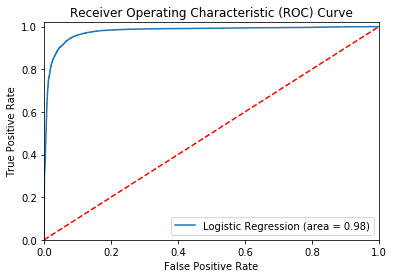

In [9]:
plot_roc_curve(y_test, probs_tfidf)

In [13]:
df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, prediction_tdidf), columns=["Negative", "Positive"])
print("{}\n\n{}".format(colored('\t\tConfusion matrix', 'blue'), df_conf_matrix))

		Confusion matrix

   Negative  Positive
0     12618       810
1      1050     12378


In [16]:
classifier = LinearSVC(max_iter=2000, random_state=0)
model = bag_of_words(classifier)
model.set_params(vect__ngram_range=(1, 4))
model.fit(samples, labels)

probs = model.decision_function(X_test)

In [30]:
coef = model.get_params()["cls"].coef_.ravel()
cv = model.get_params()["vect"]

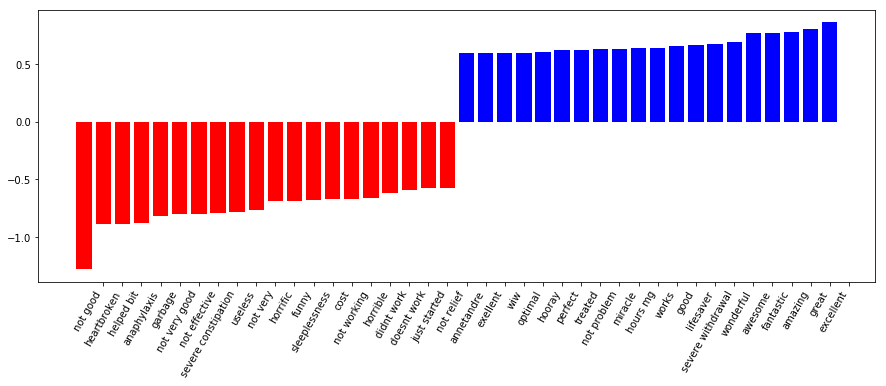

In [33]:
plot_top_features(coef, cv)